# Suitability Analysis for a New Venue Location

[![open_in_colab][colab_badge]][colab_notebook_link]
[![open_in_binder][binder_badge]][binder_notebook_link]

[colab_badge]: https://colab.research.google.com/assets/colab-badge.svg
[colab_notebook_link]: https://colab.research.google.com/github/UnfoldedInc/examples/blob/master/notebooks/10%20-%20Suitability_Analysis.ipynb
[binder_badge]: https://mybinder.org/badge_logo.svg
[binder_notebook_link]: https://mybinder.org/v2/gh/UnfoldedInc/examples/master?urlpath=lab/tree/notebooks/10%20-%20Suitability_Analysis.ipynb

## Dependencies
This notebook uses the following dependencies:

* pandas
* numpy
* scikit-learn
* matplotlib
* h3
* catboost
* missingno

If running this notebook in Binder, these dependencies should already be installed. If running in Colab, the next cell will install these dependencies. In another environment, you'll need to make sure these dependencies are available by running the following `pip` command in a shell.

```
pip install pandas numpy scikit-learn seaborn matplotlib h3 catboost missingno
```

This notebook was originally tested with the following package versions, but likely works with a broad range of versions:

* pandas==1.3.3
* numpy==1.21.2
* scikit-learn==0.24.2
* scipy==1.7.1
* matplotlib==3.4.3
* h3==3.7.3
* catboost==0.26.1
* missingno==0.5.0

In [ ]:
# If in Colab, install this notebook's required dependencies
import sys
if "google.colab" in sys.modules:
    !pip install https://cdn.unfolded.ai/map-sdk-temp/unfolded.map_sdk-0.5.0-py2.py3-none-any.whl pandas numpy scikit-learn seaborn matplotlib h3 catboost missingno

## Imports

In [1]:
from uuid import uuid4

import h3.api.numpy_int as h3
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd

%matplotlib inline
from catboost import CatBoostRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from unfolded.map_sdk import UnfoldedMap

/Users/kbarron/.pyenv/versions/3.8.10/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


## Data Loading

In [2]:
foot_traffic_url = 'https://actionengine-public.s3.us-east-2.amazonaws.com/common_df.csv'
# TODO: Save this DF without an index column
cities_url = 'https://actionengine-public.s3.us-east-2.amazonaws.com/cities.csv'

# TODO: Convert lon/lat columns to numeric here
foot_traffic_df = pd.read_csv(foot_traffic_url)
# TODO: Rename this `block_groups`?
cities_df = pd.read_csv(cities_url)

foot_traffic_df = foot_traffic_df.merge(cities_df, how='left', on=[
    "Neighbourhood Latitude", "Neighbourhood Longitude"
])

foot_traffic_df.head()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Address,Venue Latitude,Venue Longitude,Venue Category,County,raw_stop_counts,raw_device_counts,region,Total Population (Estimate),Total Population (MarginOfError),Median Household Income(Estimate),Median Household Income(MarginOfError),Unnamed: 0,block,District
0,40.824867,-73.818618,Travesias,3834 East Tremont Ave,40.82445883240027,-73.820451,Latin American Restaurant,Bronx,4184.0,1282.0,NY,1314.0,260.0,55700.0,8417.0,3804,360050158001,Bronx
1,40.824867,-73.818618,Burger Bar Ny,3841 E Tremont Ave,40.824315000000006,-73.819894,Burger Joint,Bronx,4184.0,1282.0,NY,1314.0,260.0,55700.0,8417.0,3804,360050158001,Bronx
2,40.824867,-73.818618,Uncle Al's Soul Food Kitchen,3841 E Tremont Ave,40.8243293762207,-73.819962,Southern / Soul Food Restaurant,Bronx,4184.0,1282.0,NY,1314.0,260.0,55700.0,8417.0,3804,360050158001,Bronx
3,40.824867,-73.818618,barrio bx,3764 E Tremont Ave,40.825764,-73.821561,Puerto Rican Restaurant,Bronx,4184.0,1282.0,NY,1314.0,260.0,55700.0,8417.0,3804,360050158001,Bronx
4,40.824867,-73.818618,15 Flavors NYC,3813 E Tremont Ave,40.8247318,-73.820084,Frozen Yogurt Shop,Bronx,4184.0,1282.0,NY,1314.0,260.0,55700.0,8417.0,3804,360050158001,Bronx


## Data Cleaning

In [3]:
def compute_missing_values(df):
    """Compute missing values of table"""
    # Count of rows that are missing for each column
    missing_value_counts = df.isnull().sum()

    # Names of columns that have at least one missing row
    missing_cols = missing_value_counts[missing_value_counts > 0].index

    # Percent missing within each column
    missing_value_pct = (missing_value_counts / len(df) * 100).round(1)

    # Print how many columns have missing values
    print(
        f"Out of {len(df.columns)} columns, there are {len(missing_cols)} columns with missing values.")

    # Print table with information about missing columns
    missing_df = pd.DataFrame({
        'Missing Values': missing_value_counts[missing_cols],
        '% of Total Values': missing_value_pct[missing_cols],
    })
    print(missing_df)

# Look at missing values within foot_traffic_df
compute_missing_values(foot_traffic_df)

Out of 18 columns, there are 3 columns with missing values.
                                        Missing Values  % of Total Values
Venue Address                                     3765               14.1
Median Household Income(Estimate)                 2285                8.5
Median Household Income(MarginOfError)            2554                9.5


Use missingno to graphically show which columns have missing data:

<AxesSubplot:>

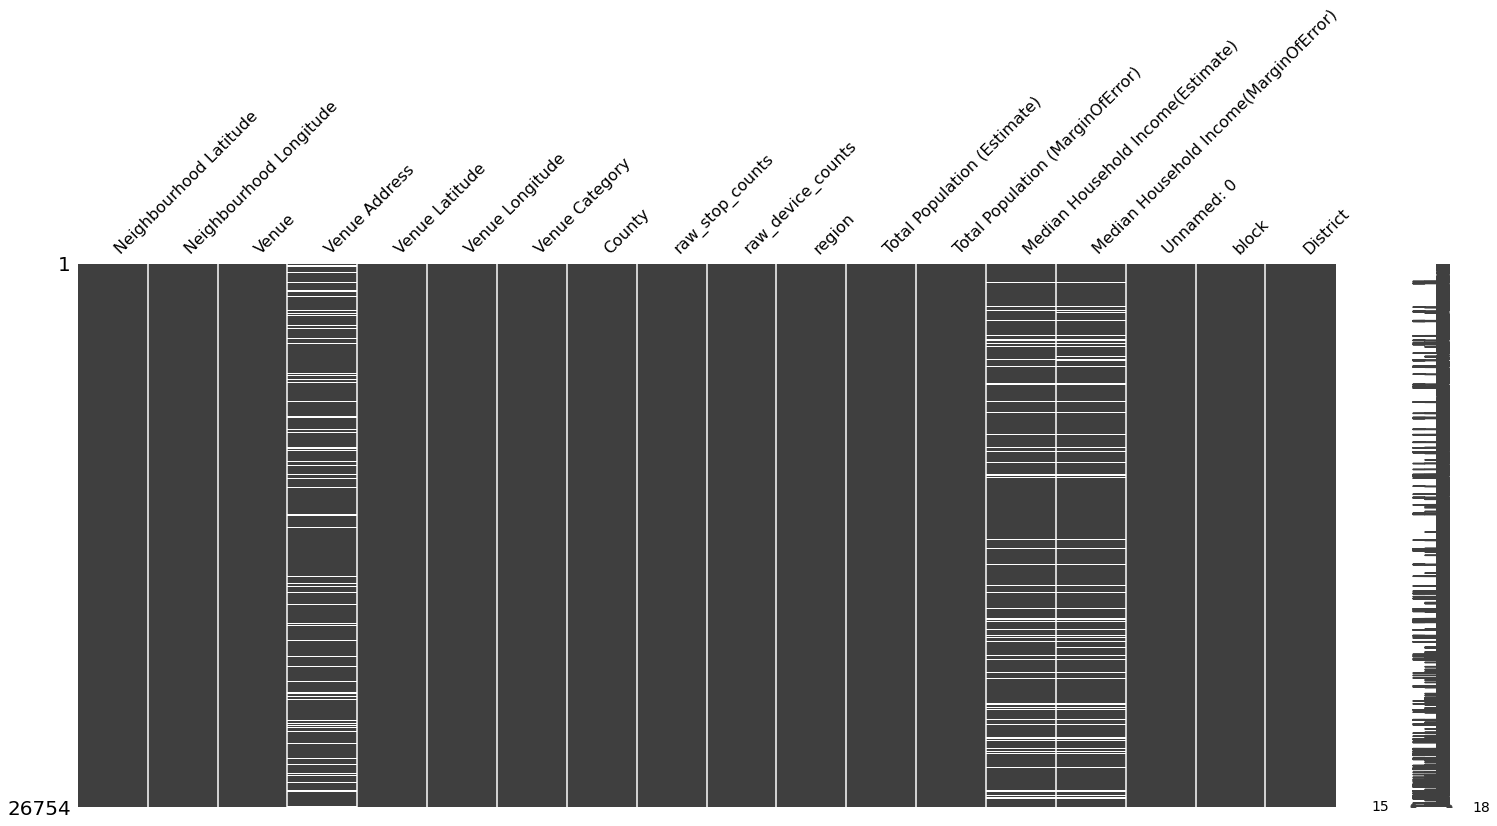

In [4]:
msno.matrix(foot_traffic_df)

There are many distinct values in the `'Venue Category'` colummn, which we can see by using `value_counts()`. Some of these categories have only one item in the data.

In [5]:
foot_traffic_df['Venue Category'].value_counts()

Deli / Bodega           3396
Pizza Place             1900
Chinese Restaurant      1653
Bakery                  1155
Coffee Shop             1125
                        ... 
Brewery                    1
Amphitheater               1
Warehouse Store            1
Dosa Place                 1
Cambodian Restaurant       1
Name: Venue Category, Length: 267, dtype: int64

Here we'll keep only the categories that have at least 10 venues. You can set your own minimum by changing `MIN_VENUES`.

In [6]:
MIN_VENUES = 10
categories = foot_traffic_df['Venue Category'].value_counts()
category_names = categories[categories >= MIN_VENUES].index
foot_traffic_df = foot_traffic_df[foot_traffic_df['Venue Category'].isin(category_names)]

## Data Visualization

Here we'll create a map that clusters by districts with the largest population. Note that since the clustering happens within Unfolded Studio, the clusters change as you zoom in, allowing you to explore your data at various resolutions.

In [7]:
neighbourhoods = foot_traffic_df.drop_duplicates(
    subset=["Neighbourhood Latitude", "Neighbourhood Longitude"]
)

population_neighbourhoods = UnfoldedMap()

# Create a persistent dataset ID that we can reference in both add_dataset and add_layer
dataset_id = uuid4()

population_neighbourhoods.add_dataset(
    {
        "uuid": dataset_id,
        "label": "population_neighbourhoods_NY",
        "data": neighbourhoods,
    },
    auto_create_layers=False,
)

population_neighbourhoods.add_layer(
    {
        "id": "population_neighbourhoods",
        "type": "cluster",
        "config": {
            "label": "population in NY",
            "data_id": dataset_id,
            "columns": {
                "lat": "Neighbourhood Latitude",
                "lng": "Neighbourhood Longitude",
            },
            "is_visible": True,
            "color_scale": "quantize",
            "color_field": {"name": "Total Population (Estimate)", "type": "real"},
            "vis_config": {
                "colorRange": {
                    "colors": [
                        "#355C7D",
                        "#63617F",
                        "#916681",
                        "#D88185",
                        "#E8998D",
                        "#F8B195",
                    ]
                }
            },
        },
    }
)
population_neighbourhoods.set_view_state(
    {"longitude": -73.769652, "latitude": 40.710574, "zoom": 9}
)

population_neighbourhoods

UnfoldedMap()

This map that clusters by districts with the largest incomes.

In [8]:
incomes_neighbourhoods = UnfoldedMap()

# Create a persistent dataset ID that we can reference in both add_dataset and add_layer
dataset_id = uuid4()

incomes_neighbourhoods.add_dataset(
    {"uuid": dataset_id, "label": "venues_NY", "data": neighbourhoods},
    auto_create_layers=False,
)

incomes_neighbourhoods.add_layer(
    {
        "id": "incomes_neighbourhoods",
        "type": "hexagon",
        "config": {
            "label": "incomes in NY by neighbourhoods",
            "data_id": dataset_id,
            "columns": {
                "lat": "Neighbourhood Latitude",
                "lng": "Neighbourhood Longitude",
            },
            "is_visible": True,
            "color_scale": "quantize",
            "color_field": {
                "name": "Median Household Income(Estimate)",
                "type": "real",
            },
            "vis_config": {
                "colorRange": {
                    "colors": [
                        "#006837",
                        "#31A354",
                        "#78C679",
                        "#ADDD8E",
                        "#D9F0A3",
                        "#FFFFCC",
                    ]
                }
            },
        },
    }
)

incomes_neighbourhoods.set_view_state(
    {"longitude": -73.769652, "latitude": 40.710574, "zoom": 9}
)

incomes_neighbourhoods

UnfoldedMap()

## Feature Engineering

Group data by district, then count the number of venues of each category for each district, and based on this, make a clustering of districts.

In [34]:
districts_by_venue_cat = (
    foot_traffic_df.groupby(["District", "Venue Category"])["Venue Category"]
    .aggregate("count")
    .unstack()
)

# The groupby creates cells with NaN values for any district that didn't have the given type of venue
# Here we replace those NaN values with 0
districts_by_venue_cat = districts_by_venue_cat.fillna(0)

# Divide each cell by the total number of venues
# We sum across the rows and then use that number 
districts_by_venue_cat = districts_by_venue_cat.div(
    districts_by_venue_cat.sum(axis=1), axis=0
)

### Feature Scaling

Using the elbow method, we determine how many clusters we can divide the data

Text(0.5, 1.0, 'Elbow Method For Optimal k')

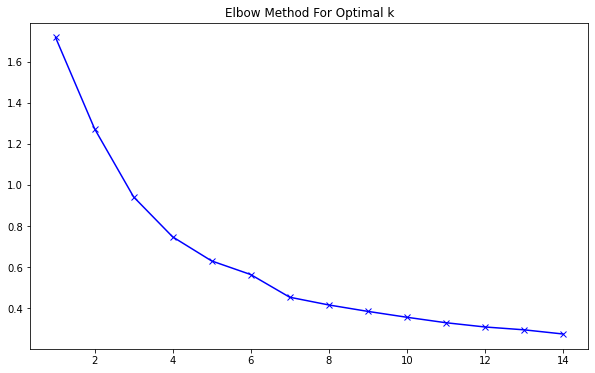

In [36]:
# Elbow method for clustering
sum_of_squared_distances = []

K = range(1, 15)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(districts_by_venue_cat)
    sum_of_squared_distances.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K, sum_of_squared_distances, "bx-")
plt.title("Elbow Method For Optimal k")

According to the graph above, the optimal value is 7

In [37]:
kclusters = 7

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(districts_by_venue_cat_copy)

districts_by_venue_cat["Label"] = kmeans.labels_

Merge the resulting cluster label back onto the main dataset `foot_traffic_df`

In [47]:
foot_traffic_df = foot_traffic_df.merge(districts_by_venue_cat[["Label"]], left_on='District', right_index=True)

We will leave only those columns that are needed to build the model.

In [49]:
final_df = foot_traffic_df[
    [
        "Neighbourhood Latitude",
        "Neighbourhood Longitude",
        "Venue Category",
        "Venue Latitude",
        "Venue Longitude",
        "County",
        "District",
        "Label",
        "Total Population (Estimate)",
        "Total Population (MarginOfError)",
        "Median Household Income(Estimate)",
        "Median Household Income(MarginOfError)",
        "raw_device_counts",
    ]
]

final_df

,Neighbourhood Latitude,Neighbourhood Longitude,Venue Category,Venue Latitude,Venue Longitude,County,District,Label,Total Population (Estimate),Total Population (MarginOfError),Median Household Income(Estimate),Median Household Income(MarginOfError),raw_device_counts
0,40.824867,-73.818618,Latin American Restaurant,40.82445883240027,-73.820451,Bronx,Bronx,6,1314.0,260.0,55700.0,8417.0,1282.0
1,40.824867,-73.818618,Burger Joint,40.824315000000006,-73.819894,Bronx,Bronx,6,1314.0,260.0,55700.0,8417.0,1282.0
2,40.824867,-73.818618,Southern / Soul Food Restaurant,40.8243293762207,-73.819962,Bronx,Bronx,6,1314.0,260.0,55700.0,8417.0,1282.0
4,40.824867,-73.818618,Frozen Yogurt Shop,40.8247318,-73.820084,Bronx,Bronx,6,1314.0,260.0,55700.0,8417.0,1282.0
5,40.824867,-73.818618,Italian Restaurant,40.82376480102539,-73.820023,Bronx,Bronx,6,1314.0,260.0,55700.0,8417.0,1282.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26101,40.559076,-73.915684,Café,40.559091,-73.912797,Queens,Breezy Point,4,989.0,264.0,78929.0,36830.0,1022.0
26102,40.559076,-73.915684,Coffee Shop,40.56115590813086,-73.911942,Queens,Breezy Point,4,989.0,264.0,78929.0,36830.0,1022.0
25966,40.752162,-73.707948,Café,40.75442362206556,-73.707419,Queens,New Hyde Park,4,1930.0,466.0,137356.0,47491.0,4296.0
25967,40.752162,-73.707948,Asian Restaurant,40.75395420119094,-73.708531,Queens,New Hyde Park,4,1930.0,466.0,137356.0,47491.0,4296.0


Visualize the principle of clustering 

In [50]:
clustering_of_district = UnfoldedMap()

# Create a persistent dataset ID that we can reference in both add_dataset and add_layer
dataset_id = uuid4()

clustering_of_district.add_dataset(
    {"uuid": dataset_id, "label": "district clustreing", "data": final_df},
    auto_create_layers=False,
)

clustering_of_district.add_layer(
    {
        "id": "incomes_neighbourhoods",
        "type": "point",
        "config": {
            "label": "incomes in NY by neighbourhoods",
            "data_id": dataset_id,
            "columns": {
                "lat": "Neighbourhood Latitude",
                "lng": "Neighbourhood Longitude",
            },
            "is_visible": True,
            "color_scale": "quantize",
            "color_field": {"name": "Label", "type": "real",},
            "vis_config": {
                "colorRange": {
                    "colors": [
                        "#B35806",
                        "#F1A340",
                        "#FEE0B6",
                        "#D8DAEB",
                        "#998EC3",
                        "#542788",
                    ]
                }
            },
        },
    }
)

clustering_of_district.set_view_state(
    {"longitude": -73.769652, "latitude": 40.710574, "zoom": 9}
)

clustering_of_district

UnfoldedMap()

## Data Preprocessing

In [56]:
final_df["Venue Latitude"] = pd.to_numeric(final_df["Venue Latitude"])
X = final_df.drop(["raw_device_counts"], axis=1)
y = final_df[["raw_device_counts"]]

/var/folders/zl/4x9vw27j60n7h41pd6ntb_pc0000gp/T/ipykernel_92890/3514484295.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df["Venue Latitude"] = pd.to_numeric(final_df["Venue Latitude"])


## Data Splitting

We split the data into training, validation and test sets

In [65]:
# dividing training data into test, validation and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=1
)

# define categorical features
cat_features = list(X.select_dtypes('object').columns)

As we mentioned before, two important columns contain empty values, for this reason fill them with median value.

In [67]:
empty_values = [
    "Median Household Income(Estimate)",
    "Median Household Income(MarginOfError)",
]

median_values = [
    X_train["Median Household Income(Estimate)"].median(axis=0),
    X_train["Median Household Income(MarginOfError)"].median(axis=0),
]


def fill_empty_values(df, columns, median_values):
    for col, med in zip(columns, median_values):
        df[col].fillna(
            med, axis=0, inplace=True,
        )


fill_empty_values(X_train, empty_values, median_values)
fill_empty_values(X_val, empty_values, median_values)
fill_empty_values(X_test, empty_values, median_values)

/Users/kbarron/.pyenv/versions/3.8.10/lib/python3.8/site-packages/pandas/core/generic.py:6383: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


## Foot Traffic Prediction Model

### Building

We use here CatBoost (new open-source machine learning algorithm, developed in 2017 by Yandex company), because it offers a way of handling categorical data. Also builds upon the theory of decision trees and gradient boosting and thus through greedy search create a strong competitive predictive model.

In [68]:
model = CatBoostRegressor(
    iterations=1000, depth=4, learning_rate=0.1, loss_function="RMSE"
)

model.fit(
    X_train, y_train, cat_features=cat_features, eval_set=(X_val, y_val), plot=True
)

pred = model.predict(X_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 4714.8894316	test: 4992.6694517	best: 4992.6694517 (0)	total: 61.4ms	remaining: 1m 1s
1:	learn: 4436.7633871	test: 4692.1012859	best: 4692.1012859 (1)	total: 65.5ms	remaining: 32.7s
2:	learn: 4182.8593425	test: 4418.4125938	best: 4418.4125938 (2)	total: 70.6ms	remaining: 23.5s
3:	learn: 3951.5638557	test: 4176.1381615	best: 4176.1381615 (3)	total: 75.3ms	remaining: 18.8s
4:	learn: 3754.1956665	test: 3959.6816301	best: 3959.6816301 (4)	total: 79.5ms	remaining: 15.8s
5:	learn: 3581.5763825	test: 3769.2493683	best: 3769.2493683 (5)	total: 83.3ms	remaining: 13.8s
6:	learn: 3446.3336319	test: 3642.8429762	best: 3642.8429762 (6)	total: 86.5ms	remaining: 12.3s
7:	learn: 3303.8127032	test: 3485.3262058	best: 3485.3262058 (7)	total: 90.4ms	remaining: 11.2s
8:	learn: 3196.3956669	test: 3404.8226415	best: 3404.8226415 (8)	total: 94.1ms	remaining: 10.4s
9:	learn: 3104.8992483	test: 3337.3154575	best: 3337.3154575 (9)	total: 97.1ms	remaining: 9.62s
10:	learn: 3016.4794993	test: 3225.36182

### H3 grid

Divide all site data with a hexagonal grid

In [75]:
final_df["h3_idx"] = final_df.apply(
    lambda row: h3.geo_to_h3(row["Venue Latitude"], row["Venue Longitude"], 10), axis=1
)

/var/folders/zl/4x9vw27j60n7h41pd6ntb_pc0000gp/T/ipykernel_92890/695775964.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df["h3_idx"] = final_df.apply(


In [20]:
# Use a lambda function to pick the _first_ mode in case there are multiple modes
mode_fn = lambda x: pd.Series.mode(x)[0]

grouped_by_h3 = final_df.groupby(["h3_idx"]).agg(
    {
        "Neighbourhood Latitude": mode_fn,
        "Neighbourhood Longitude": mode_fn,
        "County": mode_fn,
        "District": mode_fn,
        "Label": mode_fn,
        "Total Population (Estimate)": "mean",
        "Total Population (MarginOfError)": "mean",
        "Median Household Income(Estimate)": "mean",
        "Median Household Income(MarginOfError)": "mean",
    }
)
grouped_by_h3[['Venue Latitude', 'Venue Longitude']] = list(pd.Series(grouped_by_h3.index).apply(h3.h3_to_geo))

In [21]:
X_test_H3 = grouped_by_h3.reset_index()

X_test_H3["Venue Category"] = "Pizza Place"

X_test_H3 = X_test_H3[
    [
        "h3_idx",
        "Neighbourhood Latitude",
        "Neighbourhood Longitude",
        "Venue Category",
        "Venue Latitude",
        "Venue Longitude",
        "County",
        "District",
        "Label",
        "Total Population (Estimate)",
        "Total Population (MarginOfError)",
        "Median Household Income(Estimate)",
        "Median Household Income(MarginOfError)",
    ]
]

### Prediction

In [22]:
predicted_data = X_test_H3.copy()

X_test_H3 = X_test_H3.drop(["h3_idx"], axis=1)

predicted_devices_counts_by_h3 = model.predict(X_test_H3)

predicted_data["raw_device_count"] = predicted_devices_counts_by_h3

This map shows the subdivision of a city using a H3 grid.

In [23]:
raw_devices_data_by_h3 = UnfoldedMap()

# Create a persistent dataset ID that we can reference in both add_dataset and add_layer
dataset_id = uuid4()

raw_devices_data_by_h3.add_dataset(
    {"uuid": dataset_id, "label": "venues_NY", "data": predicted_data},
    auto_create_layers=False,
)

raw_devices_data_by_h3.add_layer(
    {
        "id": "raw_devices_data_by_h3",
        "type": "hexagonId",
        "config": {
            "data_id": dataset_id,
            "label": "h3_idx",
            "columns": {"hex_id": "h3_idx"},
            "color_field": {"name": "raw_device_count", "type": "real"},
            "is_visible": True,
            "vis_config": {
                "opacity": 0.8,
                "color_range": {
                    "name": "ColorBrewer Reds-6",
                    "type": "singlehue",
                    "category": "ColorBrewer",
                    "colors": [
                        "#fee5d9",
                        "#fcbba1",
                        "#fc9272",
                        "#fb6a4a",
                        "#de2d26",
                        "#a50f15",
                    ],
                },
            },
            "hidden": False,
        },
    }
)

raw_devices_data_by_h3.set_view_state(
    {"longitude": -73.769652, "latitude": 40.710574, "zoom": 9}
)

raw_devices_data_by_h3

UnfoldedMap()

### Visualize results

This map shows predicted count of devices by districts of NYC

In [24]:
venues_NY = UnfoldedMap()

# Create a persistent dataset ID that we can reference in both add_dataset and add_layer
dataset_id = uuid4()

venues_NY.add_dataset(
    {"uuid": dataset_id, "label": "venues_NY", "data": predicted_data},
    auto_create_layers=False,
)

venues_NY.add_layer(
    {
        "id": "foot_traffic_data_by_venues",
        "type": "point",
        "config": {
            "data_id": dataset_id,
            "label": "Predicted Foot Traffic By raw_device_count",
            "columns": {"lat": "Venue Latitude", "lng": "Venue Longitude"},
            "color_field": {"name": "raw_device_count", "type": "real"},
            "is_visible": True,
            "color_scale": "quantile",
            "vis_config": {
                "opacity": 0.08,
                "colorRange": {
                    "colors": [
                        "#2B1E3E",
                        "#343D5E",
                        "#4F777E",
                        "#709E87",
                        "#99BE95",
                        "#D6DEBF",
                    ],
                },
            },
        },
    }
)

venues_NY.set_view_state({"longitude": -73.769652, "latitude": 40.710574, "zoom": 9})

venues_NY

UnfoldedMap()

Visualize the results with a heatmap, we can see the areas with the highest foot traffic

In [25]:
venues_NY_heatmap = UnfoldedMap()

# Create a persistent dataset ID that we can reference in both add_dataset and add_layer
dataset_id = uuid4()

venues_NY_heatmap.add_dataset(
    {"uuid": dataset_id, "label": "venues_NY", "data": predicted_data},
    auto_create_layers=False,
)

venues_NY_heatmap.add_layer(
    {
        "id": "foot_traffic_data_by_venues",
        "type": "heatmap",
        "config": {
            "dataId": dataset_id,
            "label": "Predicted Foot Traffic By raw_device_count",
            "columns": {"lat": "Venue Latitude", "lng": "Venue Longitude"},
            "is_visible": True,
            "vis_config": {
                "opacity": 0.8,
                "colorRange": {
                    "name": "Global Warming",
                    "type": "sequential",
                    "category": "Uber",
                    "colors": [
                        "#5A1846",
                        "#900C3F",
                        "#C70039",
                        "#E3611C",
                        "#F1920E",
                        "#FFC300",
                    ],
                },
                "radius": 20,
                "intensity": 0.5,
                "threshold": 0.189,
            },
            "hidden": False,
        },
        "visual_channels": {
            "weight_field": {"name": "raw_device_count", "type": "real"},
            "weight_scale": "",
        },
    }
)

venues_NY_heatmap.set_view_state(
    {"longitude": -73.769652, "latitude": 40.710574, "zoom": 9}
)

venues_NY_heatmap

UnfoldedMap()